# Importing libraries in order to visualize and analyze our dataset

In [ ]:
import pandas as pd
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs
from numpy import mean
import os
import glob
from datetime import datetime

# Descrizione dataset e idee su come proseguire
All'interno della cartella "dataset" ci sono 315 files csv: i primi 314 sono del tipo "MovementAAL_RSS_*.csv", l'ultimo è "MovementAAL_target.csv". Ogni MovementAAL_RSS rappresenta gli spostamenti di un individuo, ma ognungo di essi è composto da un diverso numero di spostamenti recepiti e quindi da un diverso numero di righe.
Per quanto riguarda MovementAAL_target, esso è composto da 314 righe (ognuna rappresenta un individuo) e 2 colonne: la prima colonna è semplicemente un indice, la seconda contiene la variabile target, che può essere -1 o +1
- -1 indica che l'individuo non cambia stanza
- +1 indica che l'individuo cambia stanza

Il nostro obiettivo è implementare un modello di forecasting ARIMA efficace. Si può agire quindi in questo modo:


In [ ]:
path = r"C:\Users\Raffa\Desktop\Università\Hardware_and_software_for_big_data\time_series\MovementAAL\dataset"
movement_files = glob.glob(os.path.join(path,"MovementAAL_RSS_*.csv"))
Merged_MovementAAL_RSS = (pd.read_csv(f, sep=',') for f in movement_files)
Merged_MovementAAL_RSS = pd.concat(Merged_MovementAAL_RSS, ignore_index=True)
Merged_MovementAAL_RSS.to_csv("Merged_MovementAAL_RSS.csv")
Merged_MovementAAL_RSS = pd.read_csv("Merged_MovementAAL_RSS.csv")
Merged_MovementAAL_RSS.drop('Unnamed: 0',axis=1,inplace=True)


Let us rename opportunely the first column

In [ ]:
Merged_MovementAAL_RSS.rename(columns = {'#RSS_anchor1':'RSS_anchor1'}, inplace = True)
print(Merged_MovementAAL_RSS)

       RSS_anchor1   RSS_anchor2   RSS_anchor3   RSS_anchor4
0         -0.90476         -0.48       0.28571          0.30
1         -0.57143         -0.32       0.14286          0.30
2         -0.38095         -0.28      -0.14286          0.35
3         -0.28571         -0.20      -0.47619          0.35
4         -0.14286         -0.20       0.14286         -0.20
...            ...           ...           ...           ...
13192      0.19048          0.28      -0.76190         -0.55
13193      0.19048          0.40      -1.00000         -0.75
13194      0.28571          0.24      -1.00000         -0.65
13195      0.33333          0.20      -0.85714         -0.55
13196      0.42857          0.60      -1.00000         -0.60

[13197 rows x 4 columns]


Dobbiamo aggiungere una colonna che indichi l'istante di tempo secondo il formato datetime. Subito dopo vogliamo trasformala nell'indice della tabella

In [ ]:
date_sequence = pd.date_range(start='2022-05-20', periods= 13197, freq= '0.125S')
Merged_MovementAAL_RSS.insert(0,'Date',date_sequence)
Merged_MovementAAL_RSS['Date'] = pd.to_datetime(Merged_MovementAAL_RSS['Date'])

In [ ]:
Merged_MovementAAL_RSS = Merged_MovementAAL_RSS.set_index('Date')
Merged_MovementAAL_RSS

,RSS_anchor1,RSS_anchor2,RSS_anchor3,RSS_anchor4
Date,,,,
2022-05-20 00:00:00.000,-0.90476,-0.48,0.28571,0.30
2022-05-20 00:00:00.125,-0.57143,-0.32,0.14286,0.30
2022-05-20 00:00:00.250,-0.38095,-0.28,-0.14286,0.35
2022-05-20 00:00:00.375,-0.28571,-0.20,-0.47619,0.35
2022-05-20 00:00:00.500,-0.14286,-0.20,0.14286,-0.20
...,...,...,...,...
2022-05-20 00:27:29.000,0.19048,0.28,-0.76190,-0.55
2022-05-20 00:27:29.125,0.19048,0.40,-1.00000,-0.75
2022-05-20 00:27:29.250,0.28571,0.24,-1.00000,-0.65


# Test di stazionarietà
Per poter applicare **ARIMA** è necessario che la  serie storica in esame  risulti essere stazionaria, ovvero che media e varianza, se  presenti,  non cambino nel tempo. Qualora la serie non  fosse stazionaria, si procede con la differenziazione.
Per verificare la stazionarietà si utilizza il test di **Dickey – Fuller aumentato**

Test Dickey-Fuller aumentato: è un test statistico che  permette di verificare la stazionarietà o meno di una serie temporale. La serie temporale è considerata stazionaria se il valore p è basso (secondo l’ipotesi nulla) e i valori critici a intervalli di confidenza dell’1%, 5%, 10% sono il più vicini possibile alle statistiche ADF.

Limitiamoci al primo sensore per semplicità:

In [ ]:
Merged_MovementAAL_RSS_1 = Merged_MovementAAL_RSS['RSS_anchor1']
result_1 = adfuller(Merged_MovementAAL_RSS_1.dropna())
print('ADF Statistic: %f' % result_1[0])
print('p-value: %f' % result_1[1])

ADF Statistic: -7.722982
p-value: 0.000000


Notiamo che il p-value è 0: ciò vuol dire che la serie storica è già stazionaria. Per completezza visualizziamo il primo ordine di differenziazione

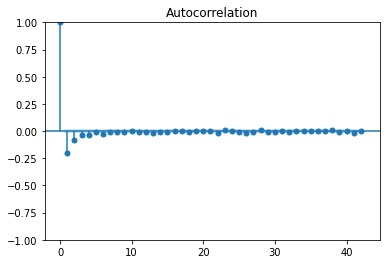

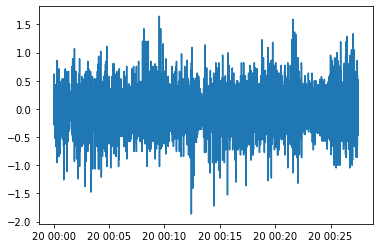

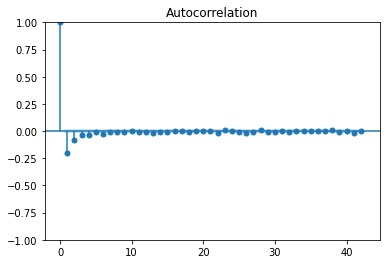

In [ ]:
plt.plot(Merged_MovementAAL_RSS_1.diff().dropna())
plot_acf(Merged_MovementAAL_RSS_1.diff().dropna())

# Valutazione dei parametri
La parte auto regressiva (AR)utilizza la relazione di dipendenza tra un’osservazione e un certo numero di osservazioni ritardate e viene definita nel modello dal parametro **p**.

Ci permette di incorporare l’effetto dei valori passati nel nostro modello. Intuitivamente, questo sarebbe simile ad affermare che è probabile che fra un ora si verifichi un evento se si è verificato nelle ultime 3 ore. 
Invece la parte di media mobile (MA)utilizza la dipendenza tra un’osservazione e un errore residuo da un modello a media mobile applicato alle osservazioni ritardate. Questo valore è rappresentato dal modello ARIMA con ilparametro **q**.
Esso consente di impostare l’errore del modello come una combinazione lineare dei valori di errore osservati in punti temporali precedenti in passato. Rappresenta una parte della serie temporale non spiegata dalla tendenza o dalla stagionalità.
All’unione di questi due modelli si aggiunge una parte integrata, che permette di gestire la differenziazione di una serie, ossia la differenza di un’osservazione da un’osservazione nella fase temporale precedente.
L’uso della differenziazione delle osservazioni grezze aiuta a rendere stazionarie le serie temporali ed è definita dal parametro **d**.
Questo parametro rappresenta il numero di trasformazioni differenziali per rendere la serie stazionaria.

# Rappresentazione grafica segnale RSS
Viene illustrato di seguito il grafico rappresentativo del RSS associato a ciascun istante di tempo

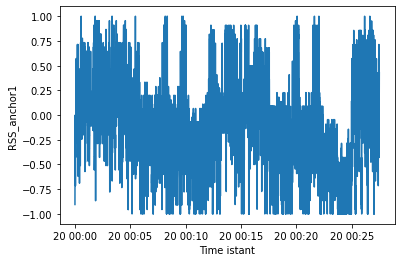

In [ ]:
plt.plot(Merged_MovementAAL_RSS_1)
plt.xlabel('Time istant')
plt.ylabel('RSS_anchor1')
plt.show()

## Parametro q
Di seguito è illustrato il grafico di autocorrelazione necessario al fine di decidere il valore del **parametro q**. Il numero di picchi non rientranti nell'int di confidenza oltre il primo sembra essere **4**.

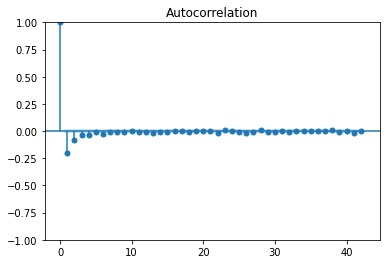

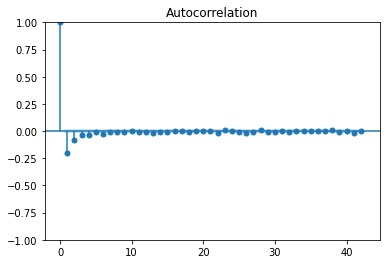

In [ ]:
plot_acf(Merged_MovementAAL_RSS_1.diff().dropna())

## Parametro p
Al fine di valutare il parametro **p**, abbiamo la necessità di effettuare l'autocorrelazione parziale al fine di scegliere il numero di picchi idonei come già visti nella precedente cella.
In questo caso il valore di p sarà pari a **13** (come prima, tolto il primo, si contano il numero di picchi al di fuori dell'intervallo che precedono il primo interno all'intervallo di confidenza).

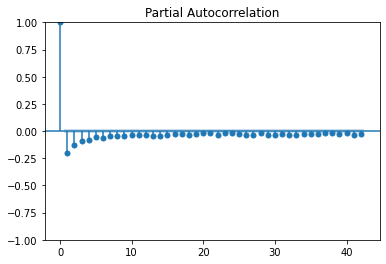

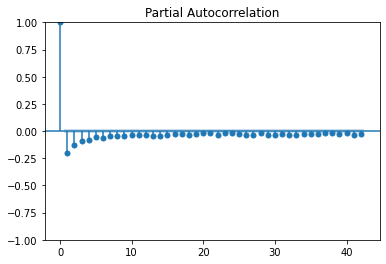

In [ ]:
plot_pacf(Merged_MovementAAL_RSS_1.diff().dropna(), method = 'ywm')

## ARIMA Model
Ora che sono stati definiti i parametri del modello p,d,q (d = 0 quando la serie è stazionaria) da utilizzare, utilizziamo il modello  richiamando  la classe ARIMA di statsmodels.

In [ ]:
model = ARIMA(Merged_MovementAAL_RSS_1, order=(5,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\Raffa\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 125L will be used.
  warnings.warn('No frequency information was'
C:\Users\Raffa\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 125L will be used.
  warnings.warn('No frequency information was'
C:\Users\Raffa\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 125L will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:            RSS_anchor1   No. Observations:                13197
Model:                 ARIMA(5, 1, 1)   Log Likelihood                1679.224
Date:                Mon, 23 May 2022   AIC                          -3344.449
Time:                        10:34:33   BIC                          -3292.035
Sample:                    05-20-2022   HQIC                         -3326.949
                         - 05-20-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6870      0.007     93.266      0.000       0.673       0.701
ar.L2          0.0662      0.009      7.198      0.000       0.048       0.084
ar.L3          0.0372      0.009      3.947      0.0

Il riepilogo del modello rivela molte informazioni. La tabella al centro rappresenta la tabella dei coefficienti in cui i valori sotto “coef” sono i pesi dei rispettivi termini. 
 
*   Le colonne **std err** sono una stima dell’errore del valore previsto. Ti dice quanto è forte l’effetto dell’errore residuo sui parametri stimati 
*   La **z** è uguale ai valori di “coef” diviso per “std err”. È quindi il coefficiente standardizzato.
*  La colonna **P > |z|** è il p-value del coefficiente. È molto importante controllare questi p-value prima di continuare a utilizzare il modello. Se uno qualsiasi di questi valori è superiore alla soglia specificata (solitamente 0,05), potresti utilizzare un coefficiente inaffidabile che potrebbe causare risultati fuorvianti.

## Suddivisione del dataset in train e test
Per eseguire la cross validation, è necessario creare il set di dati di addestramento e test suddividendo le serie temporali in 2 parti contigue con un rapporto di circa 75:25 o una proporzione ragionevole basata sulla frequenza temporale delle serie.


In [ ]:
train = Merged_MovementAAL_RSS_1[:9897]
test = Merged_MovementAAL_RSS_1[9898:]

Ora possiamo costruire il modello ARIMA sul set di dati di test, prevederlo e tracciarlo.


In [ ]:
model = ARIMA(train, order=(5, 1, 1))
fitted = model.fit()  
# Forecast
fc = fitted.get_forecast(3299, alpha=0.05)  # 95% conf
conf = fc.conf_int(alpha = 0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
#lower_series = pd.Series(conf[0,0], index=test.index)
#upper_series = pd.Series(conf[0,1], index=test.index)

# Plot
#plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
#plt.plot(test, label='actual')
#plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
 #                color='k', alpha=.15)
#plt.title('Forecast vs Actuals')
#plt.legend(loc='upper left', fontsize=8)
#plt.show()
#print(model_fit.summary())

C:\Users\Raffa\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 125L will be used.
  warnings.warn('No frequency information was'
C:\Users\Raffa\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 125L will be used.
  warnings.warn('No frequency information was'
C:\Users\Raffa\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency 125L will be used.
  warnings.warn('No frequency information was'


In [ ]:
#print(len(fc))
print(fc)

# Metriche di accuratezza

In [ ]:
# Accuracy metrics
'''def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc_series, test.values)'''

"def forecast_accuracy(forecast, actual):\n    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE\n    me = np.mean(forecast - actual)             # ME\n    mae = np.mean(np.abs(forecast - actual))    # MAE\n    mpe = np.mean((forecast - actual)/actual)   # MPE\n    rmse = np.mean((forecast - actual)**2)**.5  # RMSE\n    corr = np.corrcoef(forecast, actual)[0,1]   # corr\n    mins = np.amin(np.hstack([forecast[:,None], \n                              actual[:,None]]), axis=1)\n    maxs = np.amax(np.hstack([forecast[:,None], \n                              actual[:,None]]), axis=1)\n    minmax = 1 - np.mean(mins/maxs)             # minmax\n    acf1 = acf(fc-test)[1]                      # ACF1\n    return({'mape':mape, 'me':me, 'mae': mae, \n            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, \n            'corr':corr, 'minmax':minmax})\n\nforecast_accuracy(fc_series, test.values)"

# Predione automatica con ARIMA

Il seguente codice ci permette di ottenere quelle che sono le combinazioni dei parametri di settaggio del modello ARIMA al fine di ottenere il risultato migliore.
A tal proposito viene utilizzata la funzione **auto_arima()** che utilizza un approccio graduale per cercare più combinazioni di parametri *p,d,q* e sceglie il modello migliore con il minor **AIC**.
Il valore di **AIC** fornisce una misura della qualità della stime del modello statisco, tenendo conto sia della bontà di adattamento che della complessità del modello. Esso è basato sul concetto di entropia come misura di informazione, tramite cui valuta la quantità di informazione persa quando un dato modello è usato per descrivere la realtà. **La regola** è quella di preferire modelli con **l'AIC più basso**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(Merged_MovementAAL_RSS_1, start_p=1, start_d=0, start_q=1,
                      max_p=14, max_d=1,max_q=14, # maximum p and q
                      m=1,              # frequency of series
                      seasonal=False,    # c'è stagionalità
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
#model.information()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3170.775, Time=8.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1740.512, Time=1.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2307.723, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2504.456, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1742.509, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3301.539, Time=8.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2537.005, Time=0.76 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3334.938, Time=9.80 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2640.761, Time=0.82 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-3338.493, Time=23.72 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-2725.624, Time=1.87 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-3315.414, Time=15.42 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=16.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=11.63 sec
 ARIMA(5,1,0)(0,0,0)[0] int

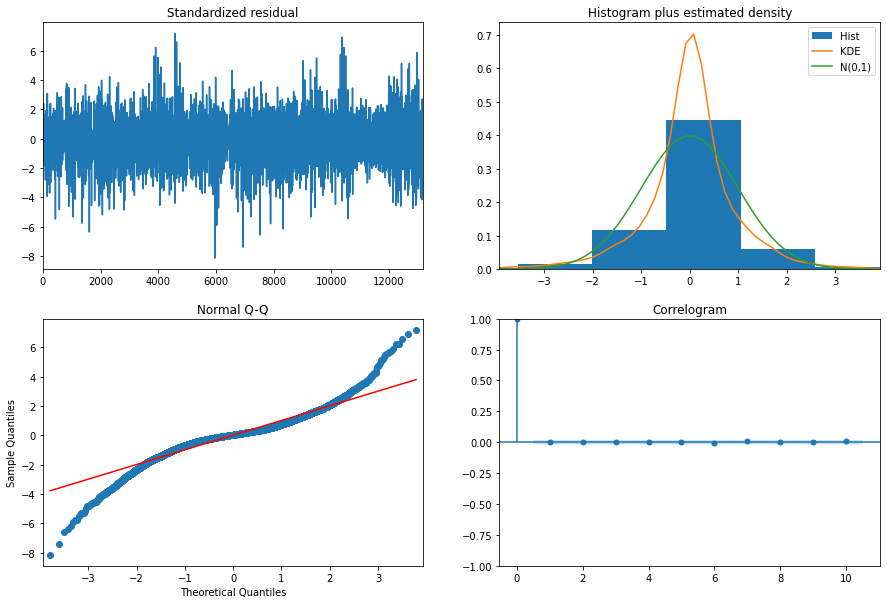

In [ ]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

## Predizione sui successivi 300 Secondi
L'obiettivo della predizione, usando il modello ARIMA è quello di predirre ovviamente cosa accadrà nel prossimo futuro.
In questo caso, è stato scelto come finestra temporale d'analisi un periodo di *3299x0.125=412.375 secondi*, settabile utilizzando la variabile *n_periods*.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


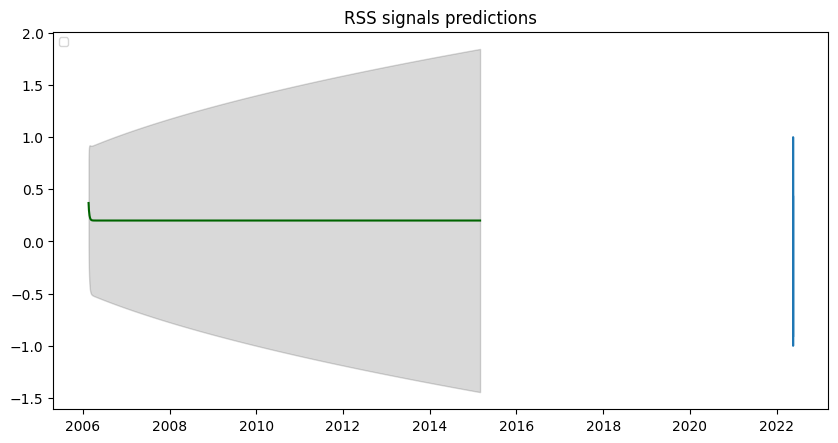

La media dei segnali RSS predetti nei prossimi 412.375 secondi è: 0.20129365539175076


In [ ]:
# Forecast
n_periods = 3299
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(Merged_MovementAAL_RSS_1), len(Merged_MovementAAL_RSS_1)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(Merged_MovementAAL_RSS_1)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title('RSS signals predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()
print("La media dei segnali RSS predetti nei prossimi 412.375 secondi è: "+str(mean(fc_series)))